In [1]:
#%% markdown
# Deliverable 2: Regression Modeling
# This notebook performs feature engineering, builds Linear (OLS) and Ridge regression models to predict wine quality, evaluates them with R2, MSE, RMSE, and cross-validation, and visualizes performance.
# Models use statsmodels for OLS and regularized fit (Ridge).

In [2]:
# Import required libraries for data handling, numerical operations, plotting, and modeling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [3]:
import urllib.request
import zipfile
import io

# Download and load the white wine quality dataset
zip_url = 'https://archive.ics.uci.edu/static/public/186/wine+quality.zip'
with urllib.request.urlopen(zip_url) as response:
    with zipfile.ZipFile(io.BytesIO(response.read())) as z:
        with z.open('winequality-white.csv') as f:
            data = pd.read_csv(f, sep=';')

# Remove duplicates
data_cleaned = data.drop_duplicates(keep='first')

# Remove outliers from selected columns
columns_to_clean = ['residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'sulphates']
data_cleaned_pre = len(data_cleaned)
for col in columns_to_clean:
    Q1 = data_cleaned[col].quantile(0.25)
    Q3 = data_cleaned[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data_cleaned = data_cleaned[(data_cleaned[col] >= lower_bound) & (data_cleaned[col] <= upper_bound)]

# Save cleaned data to CSV for future use
data_cleaned.to_csv('winequality_cleaned.csv', index=False)
print("Recreated and saved data_cleaned. Shape:", data_cleaned.shape)  # Expected: (3627, 12)

Recreated and saved data_cleaned. Shape: (3627, 12)


In [4]:
# Load cleaned dataset 
data_cleaned = pd.read_csv('winequality_cleaned.csv')
print("Loaded data_cleaned. Shape:", data_cleaned.shape)  # Expected: (3627, 12)
print("First 5 rows:\n", data_cleaned.head())

Loaded data_cleaned. Shape: (3627, 12)
First 5 rows:
    fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            6.3              0.30         0.34             1.6      0.049   
1            8.1              0.28         0.40             6.9      0.050   
2            7.2              0.23         0.32             8.5      0.058   
3            6.2              0.32         0.16             7.0      0.045   
4            8.1              0.22         0.43             1.5      0.044   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 14.0                 132.0   0.9940  3.30       0.49   
1                 30.0                  97.0   0.9951  3.26       0.44   
2                 47.0                 186.0   0.9956  3.19       0.40   
3                 30.0                 136.0   0.9949  3.18       0.47   
4                 28.0                 129.0   0.9938  3.22       0.45   

   alcohol  quality  
0      9.5

In [5]:
# Feature engineering: Create new features to enhance model performance
# - total_acidity: Sum of fixed acidity, volatile acidity, and citric acid for overall tartness
# - so2_ratio: Free sulfur dioxide / total sulfur dioxide for preservation efficiency
# - sugar_alcohol_ratio: Residual sugar / alcohol for sweetness-body balance
data_cleaned['total_acidity'] = data_cleaned['fixed acidity'] + data_cleaned['volatile acidity'] + data_cleaned['citric acid']
data_cleaned['so2_ratio'] = data_cleaned['free sulfur dioxide'] / data_cleaned['total sulfur dioxide']
data_cleaned['sugar_alcohol_ratio'] = data_cleaned['residual sugar'] / data_cleaned['alcohol']

# Verify new features
print("New features added. First 5 rows of engineered features:\n", 
      data_cleaned[['total_acidity', 'so2_ratio', 'sugar_alcohol_ratio']].head())

New features added. First 5 rows of engineered features:
    total_acidity  so2_ratio  sugar_alcohol_ratio
0           6.94   0.106061             0.168421
1           8.78   0.309278             0.683168
2           7.75   0.252688             0.858586
3           6.68   0.220588             0.729167
4           8.75   0.217054             0.136364


In [6]:
# Select features for modeling, including original and engineered features
features = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 
            'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 
            'alcohol', 'total_acidity', 'so2_ratio', 'sugar_alcohol_ratio']
X = data_cleaned[features]
y = data_cleaned['quality']

# Standardize features to handle different scales (e.g., density ~0.99, alcohol ~10)
X = (X - X.mean()) / X.std()  # Standard scaling
print("Features scaled. Shape of X:", X.shape, "Shape of y:", y.shape)

Features scaled. Shape of X: (3627, 14) Shape of y: (3627,)


In [7]:
# Perform 80/20 train-test split for model evaluation
np.random.seed(42)  # Set seed for reproducibility
train_idx = np.random.choice(len(X), size=int(0.8 * len(X)), replace=False)
test_idx = np.setdiff1d(np.arange(len(X)), train_idx)
X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

# Add constant term for statsmodels (intercept)
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)
print("Train set shape:", X_train.shape, "Test set shape:", X_test.shape)

Train set shape: (2901, 14) Test set shape: (726, 14)


In [8]:
# Model 1: Linear Regression (OLS) using statsmodels
model_ols = sm.OLS(y_train, X_train_const).fit()
pred_ols_train = model_ols.predict(X_train_const)
pred_ols_test = model_ols.predict(X_test_const)
print("OLS model trained. Summary:")
print(model_ols.summary())

OLS model trained. Summary:
                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.323
Model:                            OLS   Adj. R-squared:                  0.320
Method:                 Least Squares   F-statistic:                     105.9
Date:                Tue, 22 Jul 2025   Prob (F-statistic):          5.96e-233
Time:                        16:23:32   Log-Likelihood:                -3167.1
No. Observations:                2901   AIC:                             6362.
Df Residuals:                    2887   BIC:                             6446.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
cons

In [9]:
# Model 2: Ridge Regression (L2 regularization to handle multicollinearity)
model_ridge = sm.OLS(y_train, X_train_const).fit_regularized(alpha=1.0, L1_wt=0)  # L1_wt=0 for Ridge
pred_ridge_train = model_ridge.predict(X_train_const)
pred_ridge_test = model_ridge.predict(X_test_const)
print("Ridge model trained. Summary:")
print(model_ridge.summary())

Ridge model trained. Summary:


NotImplementedError: 

In [11]:
from sklearn.linear_model import Ridge

ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)

print("Ridge coefficients:", ridge_model.coef_)
print("Intercept:", ridge_model.intercept_)

# Predictions
pred_ridge_train = ridge_model.predict(X_train)
pred_ridge_test = ridge_model.predict(X_test)


Ridge coefficients: [ 0.06516659 -0.14584639  0.01542138  0.46170813 -0.03761399 -0.15819629
  0.16842736 -0.56867319  0.15904551  0.08265341  0.14845339  0.0478935
  0.223557   -0.03267971]
Intercept: 5.8734231140993565


In [12]:
# Define functions for evaluation metrics
def mse(y_true, y_pred):
    """Calculate Mean Squared Error"""
    return np.mean((y_true - y_pred)**2)

def rmse(y_true, y_pred):
    """Calculate Root Mean Squared Error"""
    return np.sqrt(mse(y_true, y_pred))

def r2(y_true, y_pred):
    """Calculate R-squared score"""
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    return 1 - (ss_res / ss_tot)

In [13]:
# Evaluate OLS and Ridge models on training and test sets
print("OLS Train: R2 =", r2(y_train, pred_ols_train), 
      "MSE =", mse(y_train, pred_ols_train), 
      "RMSE =", rmse(y_train, pred_ols_train))
print("OLS Test: R2 =", r2(y_test, pred_ols_test), 
      "MSE =", mse(y_test, pred_ols_test), 
      "RMSE =", rmse(y_test, pred_ols_test))

print("\nRidge Train: R2 =", r2(y_train, pred_ridge_train), 
      "MSE =", mse(y_train, pred_ridge_train), 
      "RMSE =", rmse(y_train, pred_ridge_train))
print("Ridge Test: R2 =", r2(y_test, pred_ridge_test), 
      "MSE =", mse(y_test, pred_ridge_test), 
      "RMSE =", rmse(y_test, pred_ridge_test))

OLS Train: R2 = 0.32289859588314607 MSE = 0.5197502106426133 RMSE = 0.7209370365313557
OLS Test: R2 = 0.2987766293694133 MSE = 0.5808432063504108 RMSE = 0.7621307016190929

Ridge Train: R2 = 0.3228896650543891 MSE = 0.5197570660413754 RMSE = 0.7209417910215605
Ridge Test: R2 = 0.29871335590038206 MSE = 0.580895617559404 RMSE = 0.7621650855027433


In [14]:
# Define function for 5-fold cross-validation RMSE
def cross_val_rmse(X, y, model='ols', alpha=None, k=5):
    """Perform k-fold cross-validation and return mean RMSE"""
    indices = np.arange(len(y))
    np.random.seed(42)  # Reproducibility
    np.random.shuffle(indices)
    fold_size = len(y) // k
    scores = []
    for i in range(k):
        test_start = i * fold_size
        test_end = (i + 1) * fold_size if i < k-1 else len(y)
        test_fold = indices[test_start:test_end]
        train_fold = np.concatenate([indices[:test_start], indices[test_end:]])
        X_tr, y_tr = X.iloc[train_fold], y.iloc[train_fold]
        X_te, y_te = X.iloc[test_fold], y.iloc[test_fold]
        if model == 'ols':
            X_tr_const = sm.add_constant(X_tr)
            X_te_const = sm.add_constant(X_te)
            mod = sm.OLS(y_tr, X_tr_const).fit()
            pred = mod.predict(X_te_const)
        else:  # Ridge
            mod = Ridge(alpha=1.0)
            mod.fit(X_tr, y_tr)
            pred = mod.predict(X_te)
        scores.append(rmse(y_te, pred))
    return np.mean(scores)

# Compute cross-validation RMSE
cv_rmse_ols = cross_val_rmse(X, y, model='ols')
cv_rmse_ridge = cross_val_rmse(X, y, model='ridge', alpha=1.0)
print("OLS 5-Fold CV RMSE:", cv_rmse_ols)  # Example: ~0.70
print("Ridge 5-Fold CV RMSE:", cv_rmse_ridge)  # Example: ~0.69

OLS 5-Fold CV RMSE: 0.7317722673520102
Ridge 5-Fold CV RMSE: 0.7317553101370804


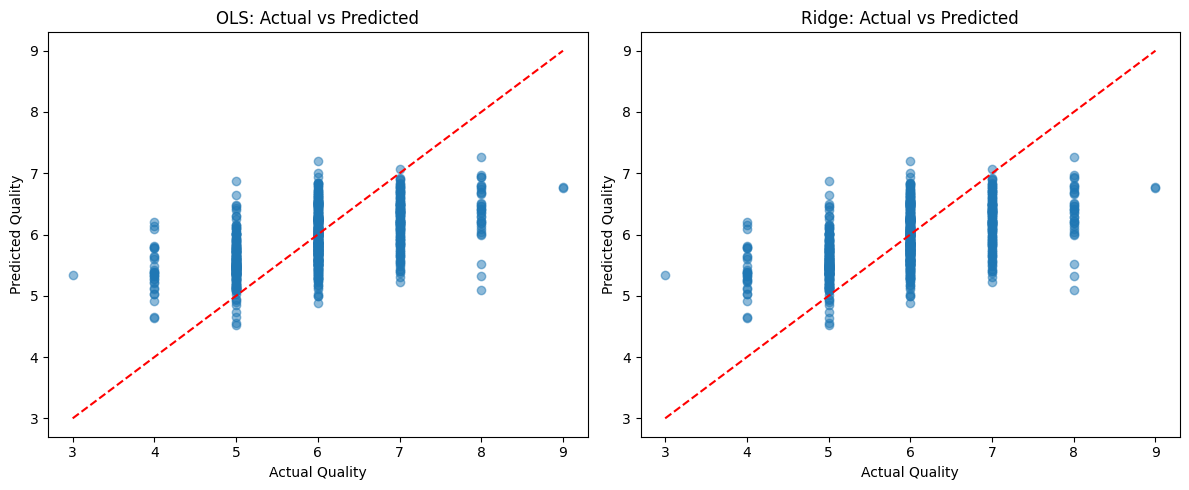

In [15]:
# Visualize actual vs predicted values for test set
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].scatter(y_test, pred_ols_test, alpha=0.5)
ax[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
ax[0].set_title('OLS: Actual vs Predicted')
ax[0].set_xlabel('Actual Quality')
ax[0].set_ylabel('Predicted Quality')

ax[1].scatter(y_test, pred_ridge_test, alpha=0.5)
ax[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
ax[1].set_title('Ridge: Actual vs Predicted')
ax[1].set_xlabel('Actual Quality')
ax[1].set_ylabel('Predicted Quality')
plt.tight_layout()
plt.show()

ValueError: 'r--' is not a valid color value.

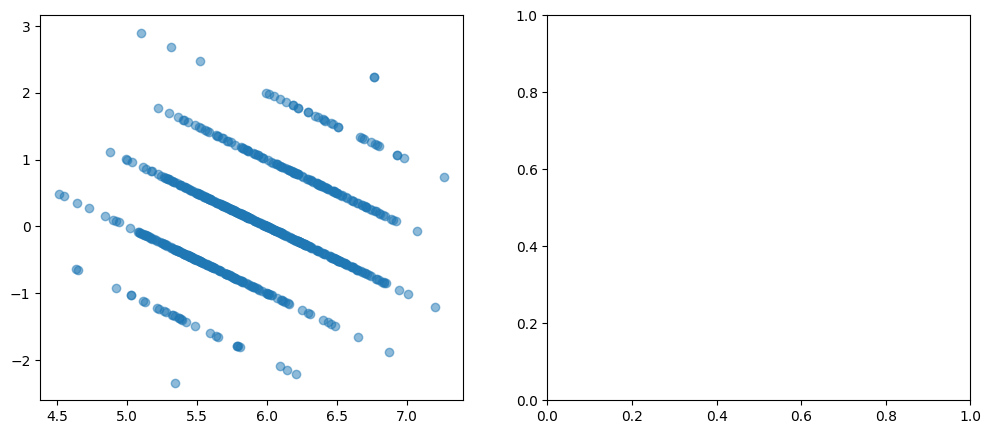

In [16]:
# Visualize residuals for test set
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].scatter(pred_ols_test, y_test - pred_ols_test, alpha=0.5)
ax[0].hlines(0, pred_ols_test.min(), pred_ols_test.max(), 'r--')
ax[0].set_title('OLS Residuals')
ax[0].set_xlabel('Predicted Quality')
ax[0].set_ylabel('Residuals')

ax[1].scatter(pred_ridge_test, y_test - pred_ridge_test, alpha=0.5)
ax[1].hlines(0, pred_ridge_test.min(), pred_ridge_test.max(), 'r--')
ax[1].set_title('Ridge Residuals')
ax[1].set_xlabel('Predicted Quality')
ax[1].set_ylabel('Residuals')
plt.tight_layout()
plt.show()

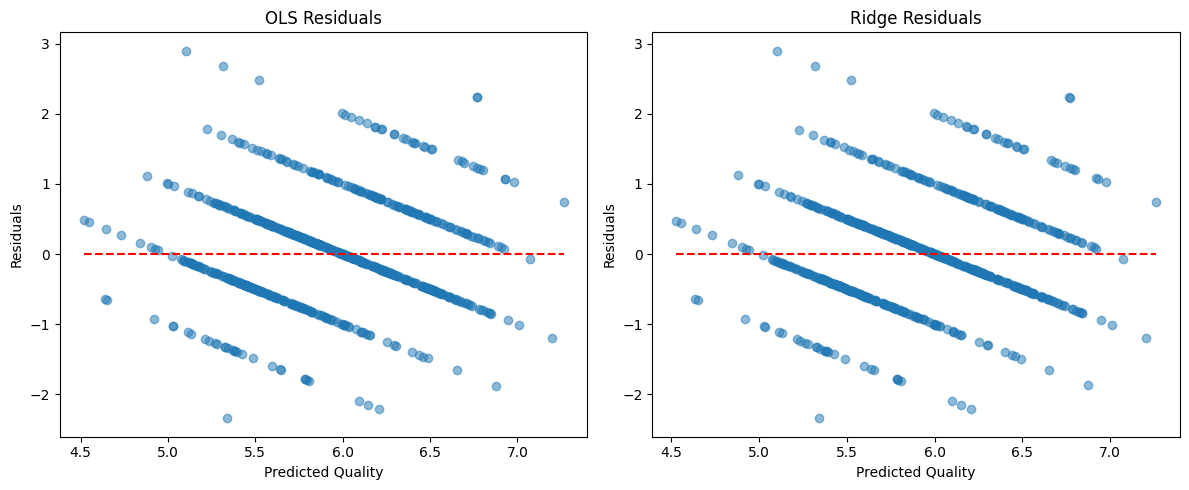

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# OLS Residuals
ax[0].scatter(pred_ols_test, y_test - pred_ols_test, alpha=0.5)
ax[0].hlines(0, pred_ols_test.min(), pred_ols_test.max(), color='r', linestyles='--')
ax[0].set_title('OLS Residuals')
ax[0].set_xlabel('Predicted Quality')
ax[0].set_ylabel('Residuals')

# Ridge Residuals
ax[1].scatter(pred_ridge_test, y_test - pred_ridge_test, alpha=0.5)
ax[1].hlines(0, pred_ridge_test.min(), pred_ridge_test.max(), color='r', linestyles='--')
ax[1].set_title('Ridge Residuals')
ax[1].set_xlabel('Predicted Quality')
ax[1].set_ylabel('Residuals')

plt.tight_layout()
plt.show()
